# Hypothesis Testing

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/v1/13_hypothesis.ipynb).

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/v1/utils.py')

import utils

This chapter introduces statistical hypothesis testing, which is such a contentious topic in the history of statistics, it's hard to provide a simple definition.
Instead, I'll start with an example, present the problem hypothesis testing is intended to solve, and then show a solution.

The solution I'll show is different from what you might find in a statistics book.
Instead of mathematical analysis, we will use computational simulations.
This approach has two advantages and one disadvantage:

* Advantage: The standard statistics curriculum includes many different tests, and many people find it hard to remember which one to use. In my opinion, simulation makes it clearer that there is only one testing framework.

* Advantage: Simulations make modeling decision explicit.  All statistical methods are based on models, but when we use mathematical methods, it is easy to forget the assumptions they are based on. With computation, the assumptions are more visible, and it is easier to try different models.

* Disadvantage: Simulation uses a lot of computation. Some of the examples in this notebook take several seconds to run; for some of them, there are analytic methods that are much faster.

The examples in this chapter include results from a clinical trial related to peanut allergies, and survey data from the National Survey of Family Growth (NSFG) and the Behavioral Risk Factor Surveillance System (BRFSS).

## Testing Medical Treatments

The LEAP study was a randomized trial that tested the effect of eating peanut snacks on the development of peanut allergies.
The subjects were infants who were at high risk of developing peanut allergies because they had been diagnosed with other food allergies.
Over a period of several years, half of the subjects were periodically given a snack containing peanuts; the other half were given no peanuts at all.

The conclusion of the study, reported in 2015 is:

> Of the children who avoided peanut, 17% developed peanut allergy by the age of 5 years. Remarkably, only 3% of the children who were randomized to eating the peanut snack developed allergy by age 5. Therefore, in high-risk infants, sustained consumption of peanut beginning in the first 11 months of life was highly effective in preventing the development of peanut allergy.

Read more about the study at <http://www.leapstudy.co.uk/leap-0#.YEJax3VKikA> and <https://www.nejm.org/doi/full/10.1056/NEJMoa1414850>.

Detailed results of the study are reported in the *New England Journal of Medicine*
In that article, Figure 1 shows the number of subjects in the treatment and control groups, which happened to be equal.

In [2]:
n_control = 314
n_treatment = 314

And from Figure 2 we can extract the number of subjects who developed peanut allergies in each group.
Specifically, we'll use the numbers from the "intention to treat analysis for both cohorts".

In [3]:
k_control = 54
k_treatment = 10

Using these numbers, we can compute the risk in each group as a percentage.

In [4]:
risk_control = k_control / n_control * 100
risk_control

17.197452229299362

In [5]:
risk_treatment = k_treatment / n_treatment * 100
risk_treatment

3.1847133757961785

These are consistent with the percentages reported in the paper.
To quantify the difference between the groups, we'll use relative risk, which is the ratio of the risks in the two groups.

In [6]:
relative_risk_actual = risk_treatment / risk_control
relative_risk_actual

0.1851851851851852

The risk in the treatment group is about 18% of the risk in the control group, which means the treatment might prevent 82% of cases.

These results seem impressive, but as skeptical data scientists we should wonder whether it is possible that we are getting fooled by randomness.
Maybe the apparent difference between the groups is due to chance, not the effectiveness of the treatment.
To see whether this is likely, we will simulate the experiment using a model where the treatment has no effect, and see how often we see such a big difference between the groups.

Let's imagine a world where the treatment is completely ineffective, so the risk is actually the same in both groups, and the difference we saw is due to chance.
If that's true, we can estimate the hypothetical risk by combining the two groups. 

In [7]:
n_all = n_control + n_treatment
k_all = k_control + k_treatment
risk_all = k_all / n_all
risk_all

0.10191082802547771

If the risk is the same for both groups, it is close to 10%.
Now we can use this hypothetical risk to simulate the experiment.
Here's `simulate_group_percent`, which we saw in Chapter 11.
It takes as parameters the size of the group, `n`, and the risk, `p`.
It simulates the experiment and returns the number of cases as a percentage of the group, which is the observed risk.

In [8]:
import numpy as np

def simulate_group_percent(n, p):
    xs = np.random.random(size=n)
    k = np.sum(xs < p)
    return k / n * 100

In [9]:
# set the random seed so we get the same results every time

np.random.seed(17)

If we call this function many times, the result is a list of observed risks, one for each simulated experiment.
Here's the list for the treatment group.

In [10]:
t1 = [simulate_group_percent(n_treatment, risk_all)
      for i in range(1000)]

And the control group.

In [11]:
t2 = [simulate_group_percent(n_control, risk_all)
      for i in range(1000)]

If we divide these lists elementwise, the result is a list of relative risks, one for each simulated experiment.

In [12]:
relative_risks = np.divide(t2, t1)

We can use a KDE plot to visualize the distribution of these results.

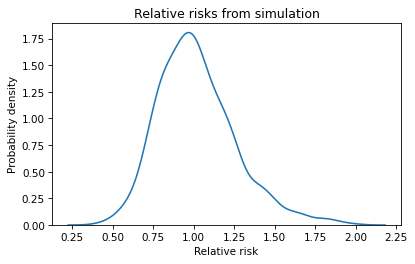

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(relative_risks)

plt.xlabel('Relative risk')
plt.ylabel('Probability density')
plt.title('Relative risks from simulation');

Remember that these simulations are based on the assumption that the risk is the same for both groups, so we expect the relative risk to be near 1 most of the time.
And it is.

In some simulated experiments, the relative risk is as low as 0.5 or as high as 2, which means it is plausible we could see results like that by chance, even if there is no difference between groups.

But the relative risk in the actual experiment was 0.18, and we never see a result as small as that in the simulated experiment.
We can conclude that the relative risk we saw is unlikely if the risk is actually the same in both groups.

## Computing p-values

Now suppose that in addition to the treatment and control groups, the experiment included a placebo group that was given a snack that contained no peanuts.
Suppose this group was the same size as the others, and 42 of the subjects developed peanut allergies.

To be clear, there was no third group, and I made up these numbers, but let's see how this hypothetical example works out.
Here's the risk in the placebo group.

In [14]:
n_placebo = 314
k_placebo = 42

risk_placebo = k_placebo / n_placebo * 100
risk_placebo

13.375796178343949

And here's the relative risk compared to the control group.

In [15]:
relative_risk_placebo = risk_placebo / risk_control
relative_risk_placebo

0.7777777777777778

The relative risk is less than 1, which means the risk in the placebo group is a bit lower than in the control group.
So we might wonder whether the placebo was actually effective.
To answer that question, at least partially, we can go back to the results from the simulated experiment.

Under the assumption that there is actually no difference between the groups, it would not be unusual to see a relative risk as low as 0.77 by chance.
In fact, we can compute the probability of seeing a relative risk as low or lower than `relative_risk_placebo`, even if the two groups are the same, like this:

In [16]:
p_value = (relative_risks <= relative_risk_placebo).mean()
p_value

0.137

This probability is called a **p-value**.
In this case, it is about 14%, which means that even if the two groups are the same, we expect to see a relative risk as low as 0.77 about 14% of the time.
So, for this imagined experiment, we can't rule out the possibility that the apparent difference is due to chance.

## Are First Babies More Likely To Be Late?

In the previous example, we computed relative risk, which is a ratio of two proportions.
As a second example, let's consider a difference between two means.

When my wife and I were expecting our first child, we heard that first babies are more likely to be born late.
But we also heard that first babies are more likely to be born early.
So which is it?
As a data scientist with too much time on my hands, I decided to find out.
I used data from the National Survey of Family Growth (NSFG), the same survey we used in Chapter 7.
At the end of that chapter, we stored a subset of the data in an HDF file.
Now we can read it back.

In [17]:
download('https://github.com/AllenDowney/' +
         'ElementsOfDataScience/raw/master/data/nsfg.hdf')

'nsfg.hdf'

In [18]:
import pandas as pd

nsfg = pd.read_hdf('nsfg.hdf', 'nsfg')
nsfg.head()

,CASEID,PREGORDR,HOWPREG_N,HOWPREG_P,MOSCURRP,NOWPRGDK,PREGEND1,PREGEND2,HOWENDDK,NBRNALIV,...,SECU,SEST,CMINTVW,CMLSTYR,CMJAN3YR,CMJAN4YR,CMJAN5YR,QUARTER,PHASE,INTVWYEAR
0,70627,1,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,3,322,1394,1382,1357,1345,1333,18,1,2016
1,70627,2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,3,322,1394,1382,1357,1345,1333,18,1,2016
2,70627,3,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,3,322,1394,1382,1357,1345,1333,18,1,2016
3,70628,1,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,2,366,1409,1397,1369,1357,1345,23,1,2017
4,70628,2,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,2,366,1409,1397,1369,1357,1345,23,1,2017


We'll use the `OUTCOME` column to select pregnancies that ended with a live birth.

In [19]:
live = (nsfg['OUTCOME'] == 1)
live.sum()

6693

And we'll use `PRGLNGTH` to select babies that were born full term, that is, during or after the 37th week of pregnancy.

In [20]:
fullterm = (nsfg['PRGLNGTH'] >= 37) & (nsfg['PRGLNGTH'] < 48)

This dataset includes data from 2724 first babies.

In [21]:
first = live & fullterm & (nsfg['BIRTHORD'] == 1)
n_first = first.sum()
n_first

2724

And 3115 other (not first) babies.

In [22]:
other = live & fullterm & (nsfg['BIRTHORD'] > 1)
n_other = other.sum()
n_other

3115

Now we can select pregnancy lengths for the first babies and others.

In [23]:
length = nsfg['PRGLNGTH']
length_first = length[first]
length_other = length[other]

Here are the mean pregnancy lengths for the two groups, in weeks.

In [24]:
print(length_first.mean(), length_other.mean())

39.39647577092511 39.19775280898877


In this dataset, first babies are born a little later on average.
The difference is about 0.2 weeks, or 33 hours.

In [25]:
diff_actual = length_first.mean() - length_other.mean()
diff_actual, diff_actual * 7 * 24

(0.19872296193634043, 33.38545760530519)

Relative to an average length of 39 weeks, that's not a very big difference.
We might wonder if a difference as big as this would be likely, even if the two groups are the same.
To answer that question, let's imagine a world where there is no difference in pregnancy length between first babies and others.
How should we model a world like that?
As always with modeling decisions, there are many options.
A simple one is to combine the two groups and compute the mean and standard deviation of pregnancy length, like this.

In [26]:
length_live_full = length[live&fullterm]
mean = length_live_full.mean()
std = length_live_full.std()
mean, std

(39.29046069532454, 1.1864094701037655)

Now we can use `simulate_sample_mean` from Chapter 11 to draw a random sample from a normal distribution with the given parameters and return the mean.

In [27]:
def simulate_sample_mean(n, mu, sigma):
    sample = np.random.normal(mu, sigma, size=n)
    return sample.mean()

If we run it 1000 times, it runs the sampling and measurement process and returns a list of results from 1000 simulated experiments.
Here are the results with sample size `n_first`:

In [28]:
t_first = [simulate_sample_mean(n_first, mean, std)
           for i in range(1000)]

And with sample size `n_other`.

In [29]:
t_other = [simulate_sample_mean(n_other, mean, std)
           for i in range(1000)]

If we subtract the simulated means elementwise, the result is a list of observed differences from simulated experiments where the distribution is the same for both groups.

In [30]:
diffs = np.subtract(t_first, t_other)

We can use a KDE plot to visualize the distribution of these values.

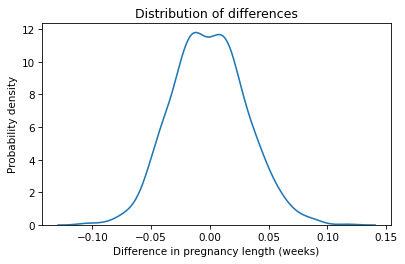

In [31]:
sns.kdeplot(diffs)

plt.xlabel('Difference in pregnancy length (weeks)')
plt.ylabel('Probability density')
plt.title('Distribution of differences');

The center of this distribution is near zero, which makes sense if the distribution in both group is the same.
Just by chance, we sometimes see differences as big as 0.1 weeks, but in 1000 simulations, we never see a difference as big as the observed difference in the data, which is almost 0.2 weeks.

Based on this result, we can pretty much rule out the possibility that the difference we saw is due to random sampling.
But we should remember that there are other possible sources of error.
For one, pregnancy lengths in the NSFG are self-reported.
When the respondents are interviewed, their recollection of first babies might be less accurate than their recollection of more recent babies.
Or the estimation of pregnancy length might be less accurate with less experienced mothers.

A correspondent of mine, who knows more than me about giving birth, suggested yet another possibility.  If a first baby is born by Caesarean section, it is more likely that subsequent deliveries will be scheduled, and less likely that they will go much past 39 weeks.
So that could bring the average down for non-first babies.

In summary, the results in this section suggest that the observed difference is unlikely to be due to chance, but there are other possible explanations.

## The Hypothesis Testing Framework

The examples we've done so far fit into the framework shown in this diagram:

![](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/hypothesis_testing.png)

Using data from an experiment, we compute the observed **test statistic**, denoted $\delta^*$ in the diagram, which quantifies the size of the observed effect.  In the peanut allergy example, the test statistic is relative risk.  In the pregnancy length example, it is the difference in the means.

Then we build a model of a world where the effect does not exist.
This model is called the **null hypothesis** and denoted $H_0$.
In the peanut allergy example, the model assumes that the risk is the same in both groups.  In the pregnancy example, it assumes that the lengths are drawn from the same normal distribution.

Next we use the model to simulate the experiment many times.
Each simulation generates a dataset which we use to compute a test statistic, $\delta$.
Finally, we collect the test statistics from the simulations and compute a p-value, which is the probability under the null hypothesis of seeing a test statistic as big as the observed effect, $\delta*$.

If the p-value is small, we can usually rule out the possibility that the observed effect is due to random variation.
But often there are other explanations we can't rule out, including measurement error and unrepresentative sampling.

I emphasize the role of the model in this framework because for a given experiment there might be several possible models, each including some elements of the real world and ignoring others.
For example, we used a normal distribution to model variation in pregnancy length.
If we don't want to make this assumption, an alternative is to simulate the null hypothesis by shuffling the pregnancy lengths.

The following function takes two sequences representing the pregnancy lengths for the two groups.
It appends them into a single sequence, shuffles it, and then splits it again into groups with the same size as the originals.
The return value is the difference in means between the groups.

In [32]:
def simulate_two_groups(data1, data2):
    n, m = len(data1), len(data2)
    data = np.append(data1, data2)
    np.random.shuffle(data)
    group1 = data[:n]
    group2 = data[n:]
    return group1.mean() - group2.mean()

If we call this function once, we get a random difference in means from a simulated world where the distribution of pregnancy lengths is the same in both groups.

In [33]:
simulate_two_groups(length_first, length_other)

-0.03111395525888838

**Exercise:** Use this function to run 1000 simulations of the null hypothesis and save the results as `diff2`.  Make a KDE plot to compare the distribution of `diff2` to the results from the normal model, `diff`.

Compute the probability of seeing a difference as big as `diff_actual`.  Is this p-value consistent with the results we got with the normal model?

In [34]:
# Solution

diffs2 = [simulate_two_groups(length_first, length_other)
          for i in range(1000)]

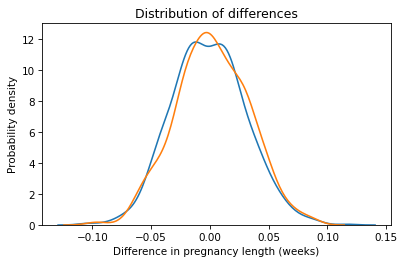

In [35]:
# Solution

# The results from the two models are similar.

sns.kdeplot(diffs)
sns.kdeplot(diffs2)

plt.xlabel('Difference in pregnancy length (weeks)')
plt.ylabel('Probability density')
plt.title('Distribution of differences');

In [36]:
# Solution

# In 1000 simulations of the null hypothesis, we never
# see a difference in means bigger than the actual difference
# in the dataset.  This result is consistent with the result
# based on the normal model.

p_value = (np.abs(diffs2) > diff_actual).mean()
p_value

0.0

**Exercise:** Are first babies more likely to be *light*?  To find out, we can use the birth weight data from the NSFG.  The variables we need use special codes to represent missing data, so let's replace them with `NaN`.

In [37]:
nsfg['BIRTHWGT_LB1'].replace([0, 98, 99], np.nan, inplace=True)
nsfg['BIRTHWGT_OZ1'].replace([0, 98, 99], np.nan, inplace=True)

And combine pounds and ounces into a single variable.

In [38]:
birthwgt = nsfg['BIRTHWGT_LB1'] + nsfg['BIRTHWGT_OZ1'] / 16

In [39]:
birthwgt.describe()

count    5768.000000
mean        7.188529
std         1.343859
min         1.062500
25%         6.437500
50%         7.312500
75%         8.062500
max        14.187500
dtype: float64

We can use `first` and `other` to select birth weights for first babies and others, dropping the `NaN` values.

In [40]:
birthwgt_first = birthwgt[first].dropna()
birthwgt_other = birthwgt[other].dropna()

In this dataset, it looks like first babies are  a little lighter, on average.

In [41]:
print(birthwgt_first.mean(), birthwgt_other.mean())

7.3370276162790695 7.507115749525616


But as usual, we should wonder whether we are being fooled by randomness.
To find out, compute the actual difference between the means.
Then use `simulate_two_groups` to simulate a world where birth weights for both groups are drawn from the same distribution.
Under the null hypothesis, how often does the difference in means exceed the actual difference in the dataset?  What conclusion can you draw from this result?

In [42]:
# Solution

birthwgt_diff = birthwgt_other.mean() - birthwgt_first.mean()
birthwgt_diff, birthwgt_diff*16

(0.17008813324654692, 2.721410131944751)

In [43]:
# Solution

birthwgt_diffs = [simulate_two_groups(birthwgt_first, 
                                      birthwgt_other)
                  for i in range(1000)]

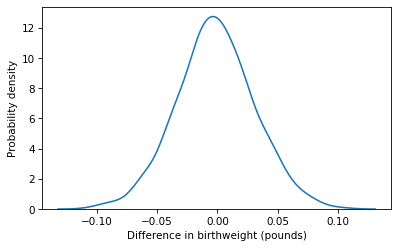

In [44]:
# Solution

# Under the null hypothesis we are very unlikely to see
# a difference as big as `birthwgt_diff`, 
# which is about 0.2 pounds.

# We can conclude that the observed difference is probably
# not due to chance, but there might be other explanations.

sns.kdeplot(birthwgt_diffs)

plt.xlabel('Difference in birthweight (pounds)')
plt.ylabel('Probability density');

## Testing Correlation

The method we used in the previous section is called a **permutation test** because we permuted the pregnancy lengths before splitting them into groups ("permute" is another word for shuffle).
As another example, in this section we'll use a permutation test to check whether an observed correlation might be due to chance.

As an example, let's look again at the correlations we computed in Chapter 9, using data from the Behavioral Risk Factor Surveillance System (BRFSS).
The following cell reads the data.

In [45]:
download('https://github.com/AllenDowney/' +
         'ElementsOfDataScience/raw/master/data/brfss.hdf')

'brfss.hdf'

In [46]:
import pandas as pd

brfss = pd.read_hdf('brfss.hdf', 'brfss')
brfss.shape

(418268, 10)

The correlations we computed were between height, weight and age.

In [47]:
columns = ['HTM4', 'WTKG3', 'AGE']
subset = brfss[columns]
corr_actual = subset.corr()
corr_actual

,HTM4,WTKG3,AGE
HTM4,1.000000,0.477151,-0.135980
WTKG3,0.477151,1.000000,-0.064951
AGE,-0.135980,-0.064951,1.000000


The correlation between height and weight is about 0.48, which is moderately strong -- if you know someone's height, you can make a better guess about their weight.
The other correlations are weaker -- for example,
knowing someone's age would not substantially improve your guesses about their height or weight.

Because these correlations are so small, we might wonder whether they are due to chance.
To answer this question, we can use permutation to simulate a world where there is actually no correlation between two variables.

But first we have to take a detour to figure out how to shuffle a Pandas `Series`.
As an example, I'll extract the height data.

In [48]:
series = brfss['HTM4']
series.head()

0    157.0
1    163.0
2    165.0
3    165.0
4    152.0
Name: HTM4, dtype: float64

The idiomatic way to shuffle a `Series` is to use `sample` with the argument `frac=1`, which means that the fraction of the elements we want is `1`, that is, all of them.
By default, `sample` chooses elements without replacement, so the result contains all of the elements in a random order.

In [49]:
shuffled = series.sample(frac=1)
shuffled.head()

56215     165.0
306509    152.0
358724    165.0
150802    178.0
221703    168.0
Name: HTM4, dtype: float64

If we check the first few elements, it seems like a random sample, so that's good.
But let's see what happens if we use the shuffled `Series` to compute a correlation.

In [50]:
corr = shuffled.corr(brfss['WTKG3'])
corr

0.4771514628388138

That result looks familiar: it is the correlation of the unshuffled columns.
The problem is that when we shuffle a `Series`, the index gets shuffled along with it.
When we compute a correlation, Pandas uses the index to line up the elements from the first `Series` with the elements of the second `Series`.
For many operations, that's the behavior we want, but in this case it defeats the purpose of shuffling!

The solution is to use `reset_index`, which gives the `Series` a new index, with the argument `drop=True`, which drops the old one.
So we have to shuffle `series` like this.

In [51]:
shuffled = series.sample(frac=1).reset_index(drop=True)

Now we can compute a correlation with the shuffled `Series`.

In [52]:
corr = shuffled.corr(brfss['WTKG3'])
corr

-0.0034178915229996325

The result is small, as we expect it to be when the elements are aligned at random.

Rather than repeat this awful idiom, let's put it in a function and never speak of it again.

In [53]:
def shuffle(series):
    return series.sample(frac=1).reset_index(drop=True)

The following function takes a `DataFrame` and two column names, makes a shuffled copy of one column, and computes its correlation with the other.

In [54]:
def simulate_correlation(df, var1, var2):
    corr = shuffle(df[var1]).corr(df[var2])
    return corr

We only have to shuffle one of the columns -- it doesn't get any more random if we shuffle both.
Now we can use this function to generate a sample of correlations with shuffled columns.

In [55]:
t = [simulate_correlation(brfss, 'HTM4', 'WTKG3')
     for i in range(200)]

Here's the distribution of the correlations.

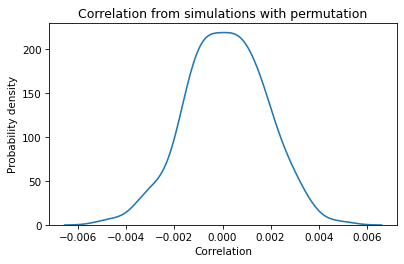

In [56]:
sns.kdeplot(t)

plt.xlabel('Correlation')
plt.ylabel('Probability density')
plt.title('Correlation from simulations with permutation');

The center of the distribution is near 0, and the largest values (positive or negative) are around 0.005.
If we compute the same distribution with different columns, the results are pretty much the same.
With samples this big, the correlation between shuffled columns is generally small.

How do these values compare to the observed correlations?  

* The correlation of height and weight is about 0.48, so it's extremely unlikely we would see a correlation as big as that by chance.

* The correlation of height and age is smaller, around -0.14, but even that value would be unlikely by chance.

* And the correlation of weight and age is even smaller, about -0.06, but that's still 10 times bigger than the biggest correlation in the simulations.

We can conclude that these correlations are probably not due to chance.
And that's useful in the sense that it rules out one possible explanation.
But this example also demonstrates a limitation of this kind of hypothesis testing.
With large sample sizes, variability due to randomness tends to be small, so it seldom explains the effects we see in real data.

And hypothesis testing can be a distraction from more important questions.
In Chapter 9, we saw that the relationship between weight and age is nonlinear.
But the coefficient of correlation only measures linear relationships, so it does not capture the real strength of the relationship.
So testing a correlation might not be the most useful thing to do in the first place.
We can do better by testing a regression model.

## Testing Regression Models

In the previous sections we used permutation to simulate a world where there is no correlation between two variables.
In this section we'll apply the same method to regression models.
As an example, we'll use NSFG data to explore the relationship between a mother's age and her baby's birth weight.

In previous sections we computed birth weight and a Boolean variable that identifies first babies.
Now we'll store them as columns in `nsfg`, so we can use them with StatsModels.

In [57]:
nsfg['BIRTHWGT'] = birthwgt
nsfg['FIRST'] = first

Next we'll select the subset of the rows that represent live, full-term births, and make a copy so we can modify the subset without affecting the original.

In [58]:
data = nsfg[live & fullterm].copy()
n = len(subset)
n

418268

To visualize the relationship between mother's age and birth weight, we'll use a box plot with mother's age grouped into 3-year bins.
We'll use `np.arange` to make the bin boundaries, and `pd.cut` to put the values from `AGECON` into bins.

In [59]:
bins = np.arange(15, 40, 3)
labels = (bins + 1)[:-1]

data['AGEGRP'] = pd.cut(data['AGECON'], 
                          bins, labels=labels)

The label for each bin is the midpoint of the range.
Now here's the box plot.

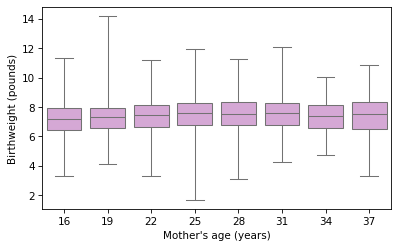

In [60]:
sns.boxplot(x='AGEGRP', y='BIRTHWGT', data=data, 
            whis=10, color='plum')

plt.xlabel("Mother's age (years)")
plt.ylabel('Birthweight (pounds)');

It looks like the average birth weight is highest if the mother is 25-31 years old, and lower if she is younger or older.
So the relationship might be nonlinear.
Nevertheless, let's start with a linear model and work our way up.
Here's a simple regression of birth weight as a function of the mother's age at conception. 

In [61]:
import statsmodels.formula.api as smf

results = smf.ols('BIRTHWGT ~ AGECON', data=data).fit()
results.params

Intercept    7.025486
AGECON       0.016407
dtype: float64

The slope of the regression line is 0.016 pounds per year, which means that if one mother is a year older than another, we expect her baby to be about 0.016 pounds heavier (about a quarter of an ounce).

In [62]:
results.params['AGECON'] * 16

0.2625196509850184

This parameter is small, so we might wonder whether the apparent effect is due to chance.
To answer that question, we'll use permutation to simulate a world where there is no relationship between mother's age and birth weight.

The following function takes a `DataFrame`, shuffles the `AGECON` column, computes a linear regression model, and returns the estimated slope.

In [63]:
def simulate_slope(data):
    data['SHUFFLED'] = shuffle(data['AGECON'])
    formula = 'BIRTHWGT ~ SHUFFLED'
    results = smf.ols(formula, data=data).fit()
    return results.params['SHUFFLED']

If we call it many times, we get a sample from the distribution of slopes under the null hypothesis.

In [64]:
np.random.seed(17)

In [65]:
rsquared_null = [simulate_slope(data)
                 for i in range(200)]

After 200 attempts, the largest slope is about 0.009, which is smaller than the observed slope, about 0.016.
We conclude that the observed effect is bigger than we would expect to see by chance.

In [66]:
print(np.max(rsquared_null), results.rsquared)

0.009536120931481635 0.007578923866134457


## Controlling for Age

In a previous exercise, you computed the difference in birth weight between first babies and others, which is about 0.17 pounds, and you checked whether we are likely to see a difference as big as that by chance.
If things went according to plan, you found that it is very unlikely.

But that doesn't necessarily mean that there is anything special about first babies that makes them lighter than others.
Rather, knowing a baby's birth order might provide information about some other factor that is related to birth weight.

The mother's age could be that factor.
First babies are likely to have younger mothers than other babies, and younger mothers tend to have lighter babies.
The difference we see in first babies might be explained by their mothers' ages.
So let's see what happens if we control for age.
Here's a simple regression of birth weight as a function of the Boolean variable `FIRST`.

In [67]:
formula = 'BIRTHWGT ~ FIRST'
results = smf.ols(formula, data=data).fit()
results.params

Intercept        7.507116
FIRST[T.True]   -0.170088
dtype: float64

The parameter associated with `FIRST` is -0.17 pounds, which is the same as the difference in means we computed.
But now we can add `AGECON` as a control variable.

In [68]:
formula = 'BIRTHWGT ~ FIRST + AGECON'
results = smf.ols(formula, data=data).fit()
results.params

Intercept        7.163240
FIRST[T.True]   -0.121771
AGECON           0.013145
dtype: float64

The age effect accounts for some of the difference between first babies and others.
After controlling for age, the remaining difference is about 0.12 pounds.

Since the age effect is nonlinear, we can can control for age more effectively by adding `AGECON2`.

In [69]:
data['AGECON2'] = data['AGECON'] ** 2

In [70]:
formula = 'BIRTHWGT ~ FIRST + AGECON + AGECON2'
results = smf.ols(formula, data=data).fit()
results.params

Intercept        6.128590
FIRST[T.True]   -0.099338
AGECON           0.096781
AGECON2         -0.001615
dtype: float64

In [71]:
slope_actual = results.params['FIRST[T.True]']
slope_actual

-0.09933806121560428

When we use a quadratic model to control for the age effect, the remaining difference between first babies and others is smaller again, about 0.10 pounds.

One of the warning signs of a spurious relationship between two variables is that the effect gradually disappears as you add control variables.
So we should wonder whether the remaining effect might be due to chance.
To find out, we'll use the following function, which simulates a world where there is no difference in weight between first babies and others.
It takes a `DataFrame` as a parameter, shuffles the `FIRST` column, runs the regression model with `AGECON` and `AGECON2`, and returns the estimated difference.

In [72]:
def simulate_slope2(data):
    data['SHUFFLED'] = shuffle(data['FIRST'])
    formula = 'BIRTHWGT ~ AGECON + AGECON2 + C(SHUFFLED)'
    results = smf.ols(formula, data=data).fit()
    return results.params['C(SHUFFLED)[T.True]']

If we run it many times, we get a sample from the distribution of the test statistic under the null hypothesis.

In [73]:
np.random.seed(17)

In [74]:
slopes_null = [simulate_slope2(data)
               for i in range(200)]

The range of values is wide enough that it occasionally exceeds the observed effect size.

In [75]:
print(min(slopes_null), max(slopes_null))

-0.09842209405975708 0.11993351438646496


The p-value is between 1% and 2%.

In [76]:
p_value = (np.abs(slopes_null) > np.abs(slope_actual)).mean()
p_value

0.02

This result indicates that an observed difference of 0.1 pounds is possible, but not likely, if the actual difference between the groups is zero.

So how should we interpret a result like this?
In the tradition of statistical hypothesis testing, it is common to use 5% as the threshold between results that are considered "statistically significant" or not.
By that standard, the weight difference between first babies and others is statistically significant.

However, there are several problems with this practice:

* First, the choice of the threshold should depend on the context. For a life-and-death decision, we might choose a more stringent threshold. For a topic of idle curiosity, like this one, we could be more relaxed.

* But it might not be useful to apply a threshold at all. An alternative (which is common in practice) is to report the p-value and let it speak for itself. It provides no additional value to declare that the result is significant or not.

* Finally, the use of the word "significant" is dangerously misleading, because it implies that the result is important in practice. But a small p-value only means that an observed effect would be unlikely to happen by chance. It doesn't mean it is important.

This last point is particularly problematic with large datasets, because very small effects can be statistically significant.
We saw an example with the BRFSS dataset, where the correlations we tested were *all* statistically significant, even the ones that are too small to matter in practice.

## Summary

Let's review the examples in this chapter:

1. We started with data from LEAP, which studied the effect of eating peanuts on the development of peanut allergies. The test statistic was relative risk, and the null hypothesis was that the treatment was ineffective.

2. Then we looked at the difference in pregnancy length for first babies and others. We used the difference in means as the test statistic, and two models of the null hypothesis: one based on a normal model and the other based on permutation of the data. As an exercise, you tested the difference in weight between first babies and others.

3. Next we used permutation to test correlations, using height, weight, and age data from the BRFSS. This example shows that with large sample sizes, observed effects are often "statistically significant", even if they are too small to matter in practice.

4. We used regression models to explore the effect of maternal age on birth weight. To see whether the effect might be due to chance, we used the slope of the regression line as the test statistic, and permutation to model the null hypothesis.

5. Finally, we explored the possibility that the first baby effect is actually an indirect maternal age effect.  After controlling for the mother's age, we tested whether the remaining difference between first babies and others might happen by chance. We used permutation to model the null hypothesis and the estimated slope as a test statistic.

As a final exercise, below, you can use the same methods to explore the effect of paternal age on birth weight.

**Exercise:** A paternal age effect is a relationship between the age of a father and a variety of outcomes for his children.
There is some evidence that young fathers and old fathers have lighter babies, on average, than fathers in the middle range of ages.
Let's see if that's true for the babies in the NSFG dataset.
The `HPAGELB` column encodes the father's age.

[See here for more about the paternal age effect](https://en.wikipedia.org/wiki/Paternal_age_effect)

Here are the values, after replacing the codes for missing data with `NaN`.

In [77]:
data['HPAGELB'].replace([98, 99], np.nan, inplace=True)
data['HPAGELB'].value_counts().sort_index()

HPAGELB
1.0     478
2.0    1391
3.0    1650
4.0    1225
5.0     592
6.0     411
Name: count, dtype: int64

And here's what the codes mean:

Code | Age
---- | -------------------
1    | Under 20 years
2    | 20-24 years
3    | 25-29 years
4    | 30-34 years
5    | 35-39 years
6    | 40 years or older

Let's create a new column that's true for the fathers in the youngest and oldest groups.
The `isin` method checks whether the values in a `Series` are in the given list.
The values `1` and `6` indicate fathers under 20 years of age or over 40.

In [78]:
data['YO_DAD'] = data['HPAGELB'].isin([1, 6])

We can use the result in a regression model to compute the difference in birth weight for young and old fathers compared to the others.

In [79]:
formula = 'BIRTHWGT ~ YO_DAD'
results = smf.ols(formula, data=data).fit()
results.params

Intercept         7.447477
YO_DAD[T.True]   -0.140045
dtype: float64

The difference is negative, which is consistent with the theory, and about 0.14 pounds, which is comparable in size to the (apparent) first baby effect.
But there is a strong correlation between father's age and mother's age.
So what seems like a paternal effect might actually be an indirect maternal effect.
To find out, let's see what happens if we control for the mother's age.
Run this model again with `AGECON` and `AGECON2` as predictors.  Does the observed effect of paternal age get smaller?

To see if the remaining effect could be due to randomness, write a function that shuffles `YO_DAD`, runs the regression model, and returns the parameter associated with the shuffled column.
How often does this parameter exceed the observed value?
What conclusion can we draw from the results?

In [80]:
# Solution

formula = 'BIRTHWGT ~ YO_DAD + AGECON'
results = smf.ols(formula, data=data).fit()
results.params

Intercept         7.055844
YO_DAD[T.True]   -0.124704
AGECON            0.015951
dtype: float64

In [81]:
# Solution

formula = 'BIRTHWGT ~ YO_DAD + AGECON + AGECON2'
results = smf.ols(formula, data=data).fit()
results.params

Intercept         6.019489
YO_DAD[T.True]   -0.046431
AGECON            0.099932
AGECON2          -0.001628
dtype: float64

In [82]:
# Solution

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               BIRTHWGT   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     20.48
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           3.45e-13
Time:                        11:40:21   Log-Likelihood:                -7618.1
No. Observations:                5043   AIC:                         1.524e+04
Df Residuals:                    5039   BIC:                         1.527e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.0195      0.282     21.350      0.000       5.467       6.572
YO_DAD[T.True]    -0.0464      0.048     -0.976      0.329      -0.140       0.047
AGECON             0.0999      0.022      4.471      0.000       0.056       0.144
AGECON2           -0.0016      0.000     -3.784      0.000      -0.002      -0.001
==============================================================================
Omnibus:                       95.395   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.605
Skew:                           0.134   Prob(JB):                     5.45e-38
Kurtosis:                       3.863   Cond. No.                     1.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
# Solution

slope_actual2 = results.params['YO_DAD[T.True]']
slope_actual2

-0.04643110077857537

In [84]:
# Solution

def simulate_slope2(data):
    data['SHUFFLED'] = shuffle(data['YO_DAD'])
    formula = 'BIRTHWGT ~ AGECON + AGECON2 + C(SHUFFLED)'
    results = smf.ols(formula, data=data).fit()
    return results.params['C(SHUFFLED)[T.True]']

In [85]:
np.random.seed(17)

In [86]:
# Solution

slopes_null2 = [simulate_slope2(data)
                for i in range(200)]

In [87]:
# Solution

print(min(slopes_null2), max(slopes_null2))

-0.1653326200452824 0.16051288758494306


In [88]:
# Solution

# The p-value is about 37%, which means that a difference
# as big as the apparent effect could happen by chance.
# We can conclude that this dataset does not provide evidence
# for a paternal age effect on birth weight. 

p_value = (np.abs(slopes_null2) > np.abs(slope_actual2)).mean()
p_value

0.37

*Elements of Data Science*

Copyright 2021 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)